In [48]:
import sys
from pathlib import Path

import cv2
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [22]:
from config import *

In [23]:
csv_file = data_meta / "all_info.csv"

# Read dataframe containing images information
df = pd.read_csv(csv_file)

In [33]:
df.Location = df.Location.astype(str)

In [24]:
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)
    
import utils as utils

# Read masks image and corresponding intensity measurement

In [25]:
# Read mask image
masks = utils.get_masks(data_mask)

# Create image based on intensity level of expression 

In [27]:
df_intensity = pd.read_csv(data_meta / 'measurements_intensity.csv')
df_morph = pd.read_csv(data_meta / 'measurements_morphology.csv')
markers = df_intensity.Marker.unique()

In [28]:
# Calculate total intensity from mena intensity and area size
for row in df_intensity.itertuples():
    cond = row.Location
    i = row.Id
    total_nuclei_intensity = row.Nuclei_mean_intensity * \
        df_morph[(df_morph.Location == cond) & (
            df_morph.Id == i)]['Nuclei_area'].item()
    total_cyto_intensity = row.Cyto_mean_intensity * \
        df_morph[(df_morph.Location == cond) & (
            df_morph.Id == i)]['Cyto_area'].item()
    df_intensity.loc[row.Index,
                     'Nuclei_total_intensity'] = total_nuclei_intensity
    df_intensity.loc[row.Index, 'Cyto_total_intensity'] = total_cyto_intensity

We have {{len(markers)}} markers (no including DAPI and cell segmentation markers) 

In [68]:
def create_expression_img(mask_cyto, mask_nuclei, df, mean=True):
    markers = df.Marker.unique()
    imgs = []

    cell = np.zeros((mask_cyto.shape), dtype=np.uint8)
    nuclei = np.zeros((mask_cyto.shape), dtype=np.uint8)
    cyto = np.zeros((mask_cyto.shape), dtype=np.uint8)

    for label in range(1, mask_cyto.max()):
        # Check if cell has nuclei
        cell_mask = np.where(mask_cyto == label, 1, 0).astype(np.uint8)
        maski = cv2.bitwise_and(mask_nuclei, mask_nuclei, mask=cell_mask)

        # If no nuclei detected then pass
        if maski.max() == 0:
            continue

        # Link label accross cell, nuclei, cyto
        cell = np.where(mask_cyto == label, label, cell)
        nuclei = np.where(maski > 0, label, nuclei)
        maski = cv2.subtract(cell_mask, maski)
        cyto = np.where(maski > 0, label, cyto)

    for marker in markers:
        img = np.zeros((mask_cyto.shape), dtype=np.uint16)
        for label in df.Id.unique():
            row = df[(df.Id == label) & (df.Marker == marker)]
            if mean: 
                nuclei_intensity = row['Nuclei_mean_intensity'].item()
                cyto_intensity = row['Cyto_mean_intensity'].item()
            else:
                nuclei_intensity = row['Nuclei_total_intensity'].item()
                cyto_intensity = row['Cyto_total_intensity'].item()
            img = np.where(cyto == label, cyto_intensity, img)
            img = np.where(nuclei == label, nuclei_intensity, img)
        imgs.append(img)
    return imgs, markers

def plot_expression_img(imgs, markers, condition, mean=True):
    # Generate figure
    cmap = pl.cm.bwr
    bg_color = np.array([[0, 0, 0, 1]])
    colors = np.concatenate((bg_color, cmap(np.linspace(0, 1, 256))))
    my_cmap = plt.cm.colors.ListedColormap(colors)
    
    fig, axs = plt.subplots(4, 4, figsize=(30, 25))
    axs = axs.flatten()
    for idx, ax in enumerate(axs):
        try:
            im = ax.imshow(imgs[idx], cmap=my_cmap)
            ax.title.set_text(markers[idx])
        except:
            pass
        ax.axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.1)

    # Add colobar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.35, 0.01, 0.3])
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=np.linspace(0, 1, 3),
                        cax=cbar_ax)
    cbar.set_label('Relative intensity', rotation=270,
                   fontsize=15, labelpad=20)
    cbar.ax.set_yticklabels(['0', '0.5', '1'])

    # Save fig and show
    if mean:
        name = condition+'_expression_level.png'
    else:
        name = condition+'_expression_level_total.png'
    fig.savefig(name,
                bbox_inches='tight', dpi=100)
    plt.show()

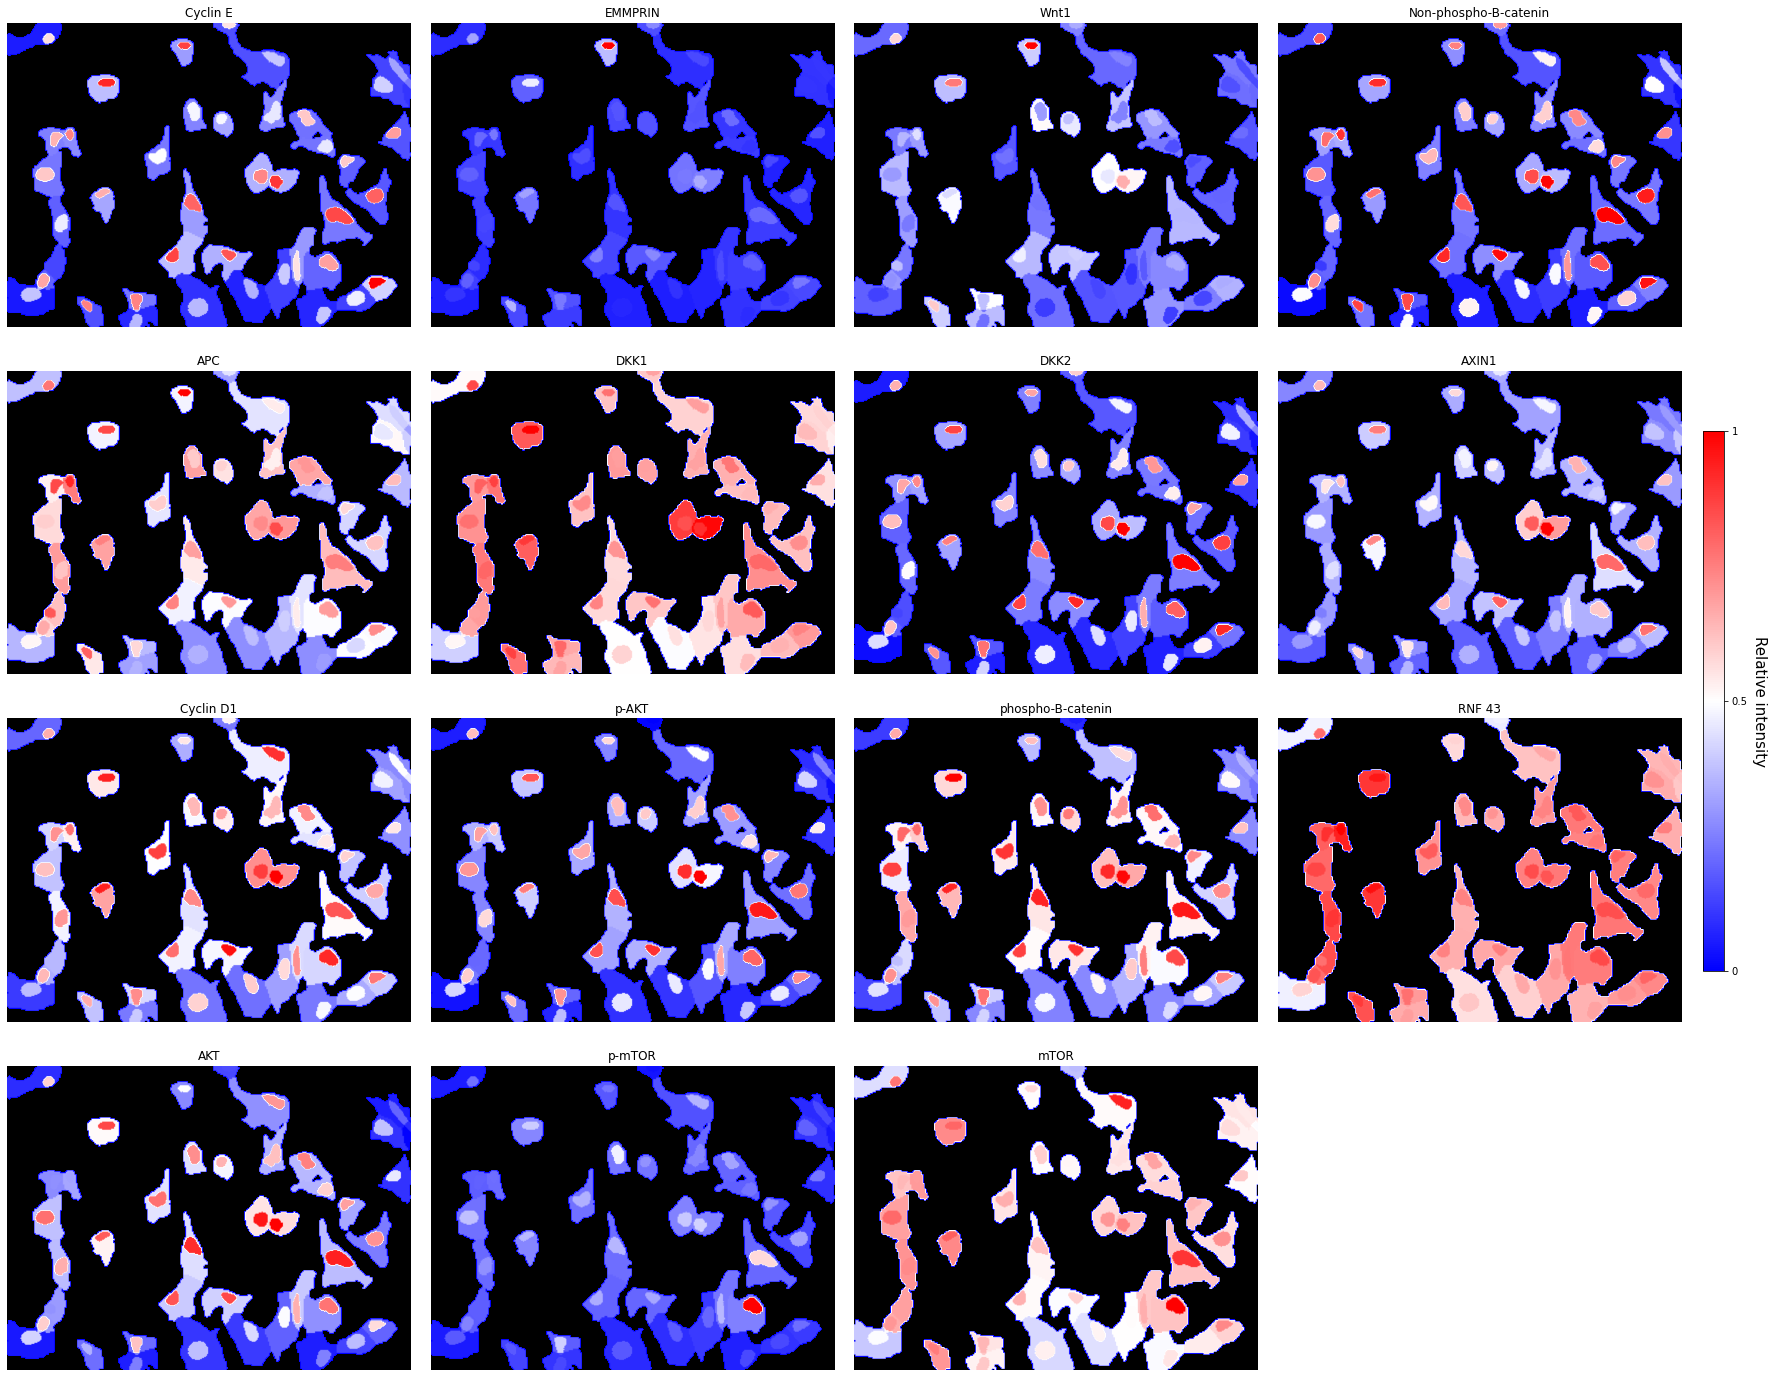

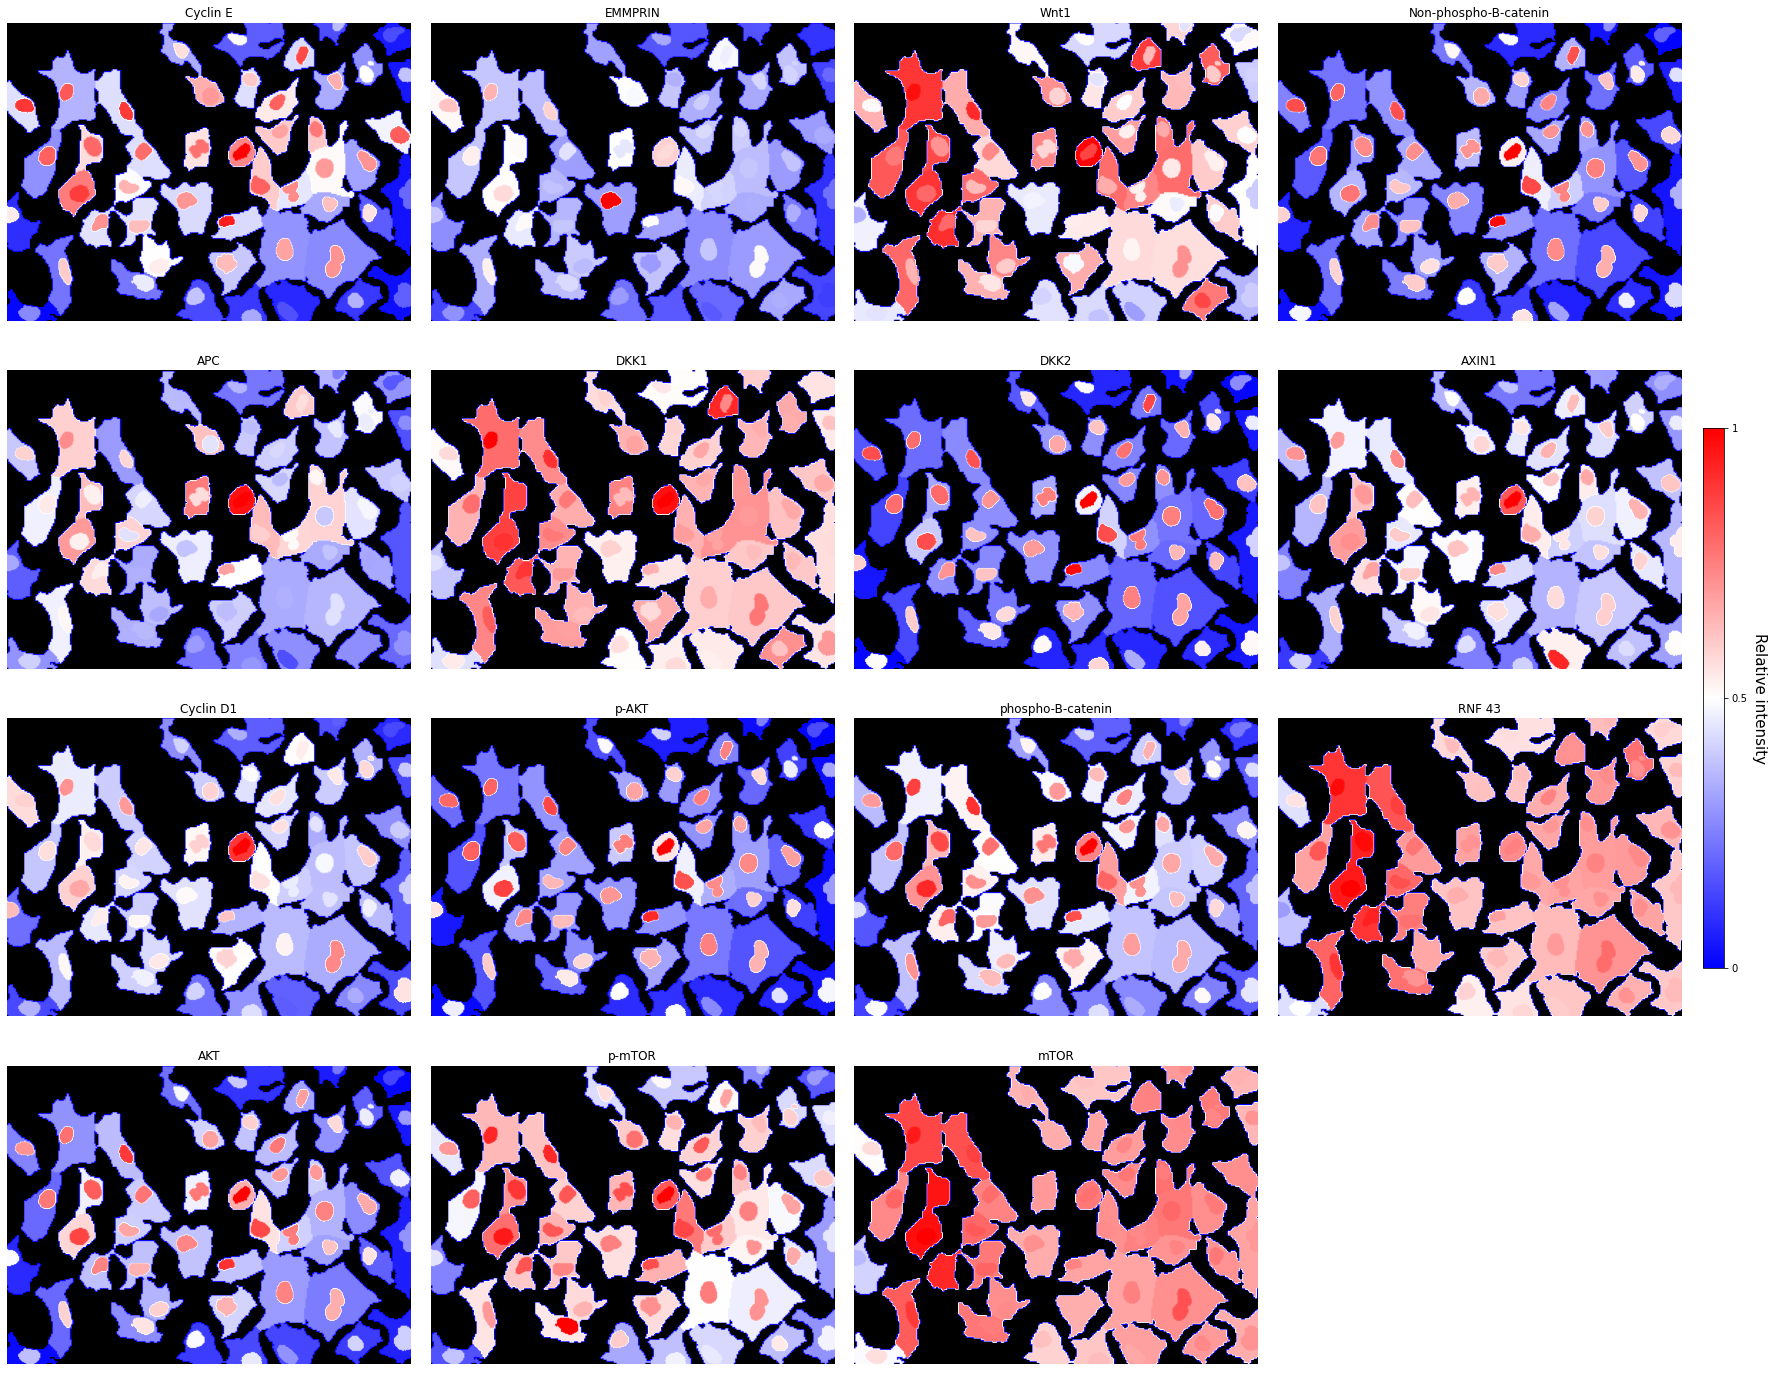

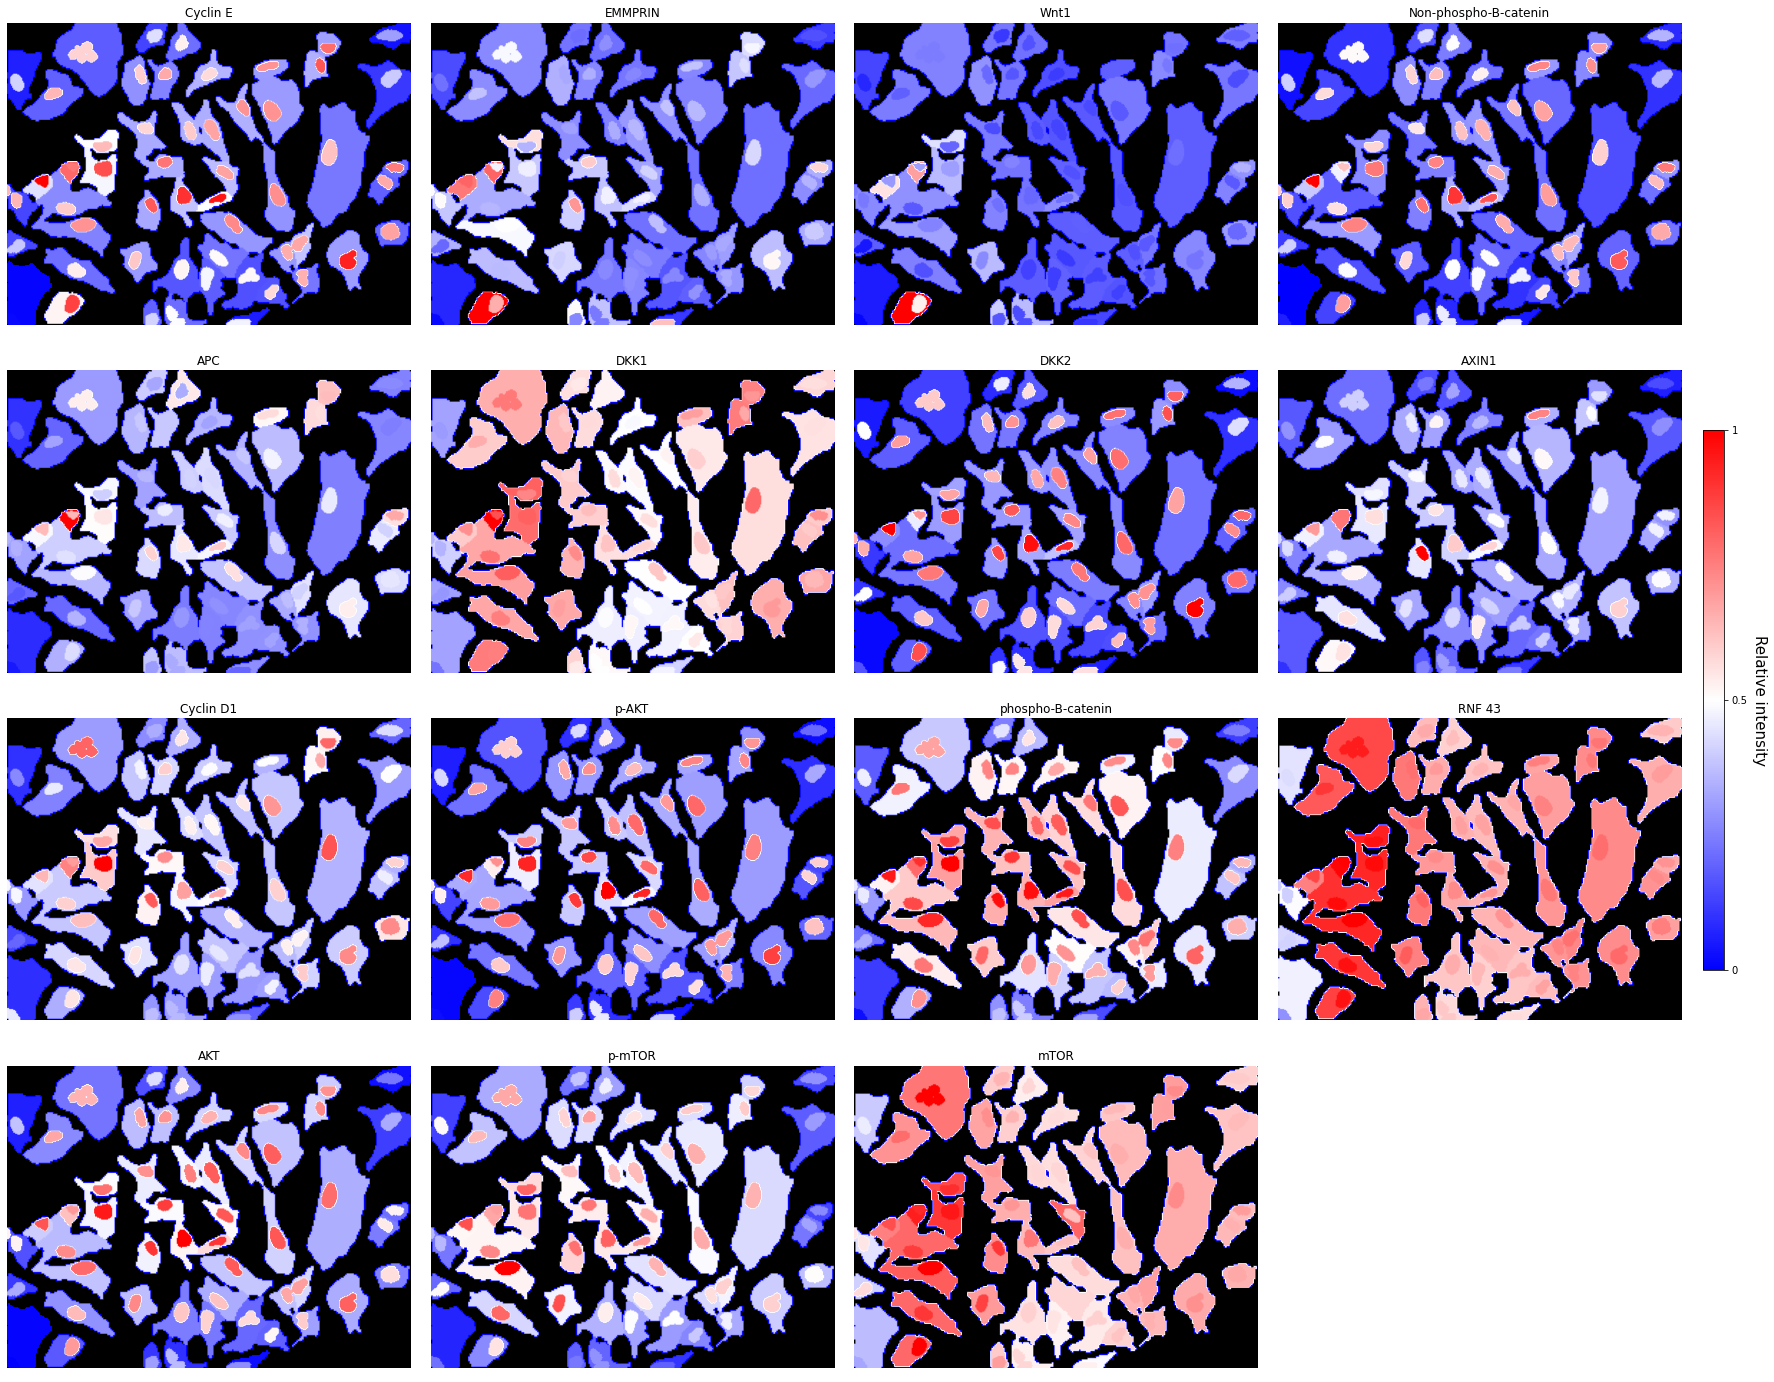

In [69]:
# Show mean intensity 

for idx, condition in enumerate(masks.keys()):
    mask_cyto = masks[condition]['cyto']
    mask_nuclei = masks[condition]['nuclei']
    df_intensity_subset = df_intensity[df_intensity.Location == int(condition)]
    imgs, markers = create_expression_img(
        mask_cyto, mask_nuclei, df_intensity_subset)
    
    # Generate figure
    plot_expression_img(imgs, markers, condition)

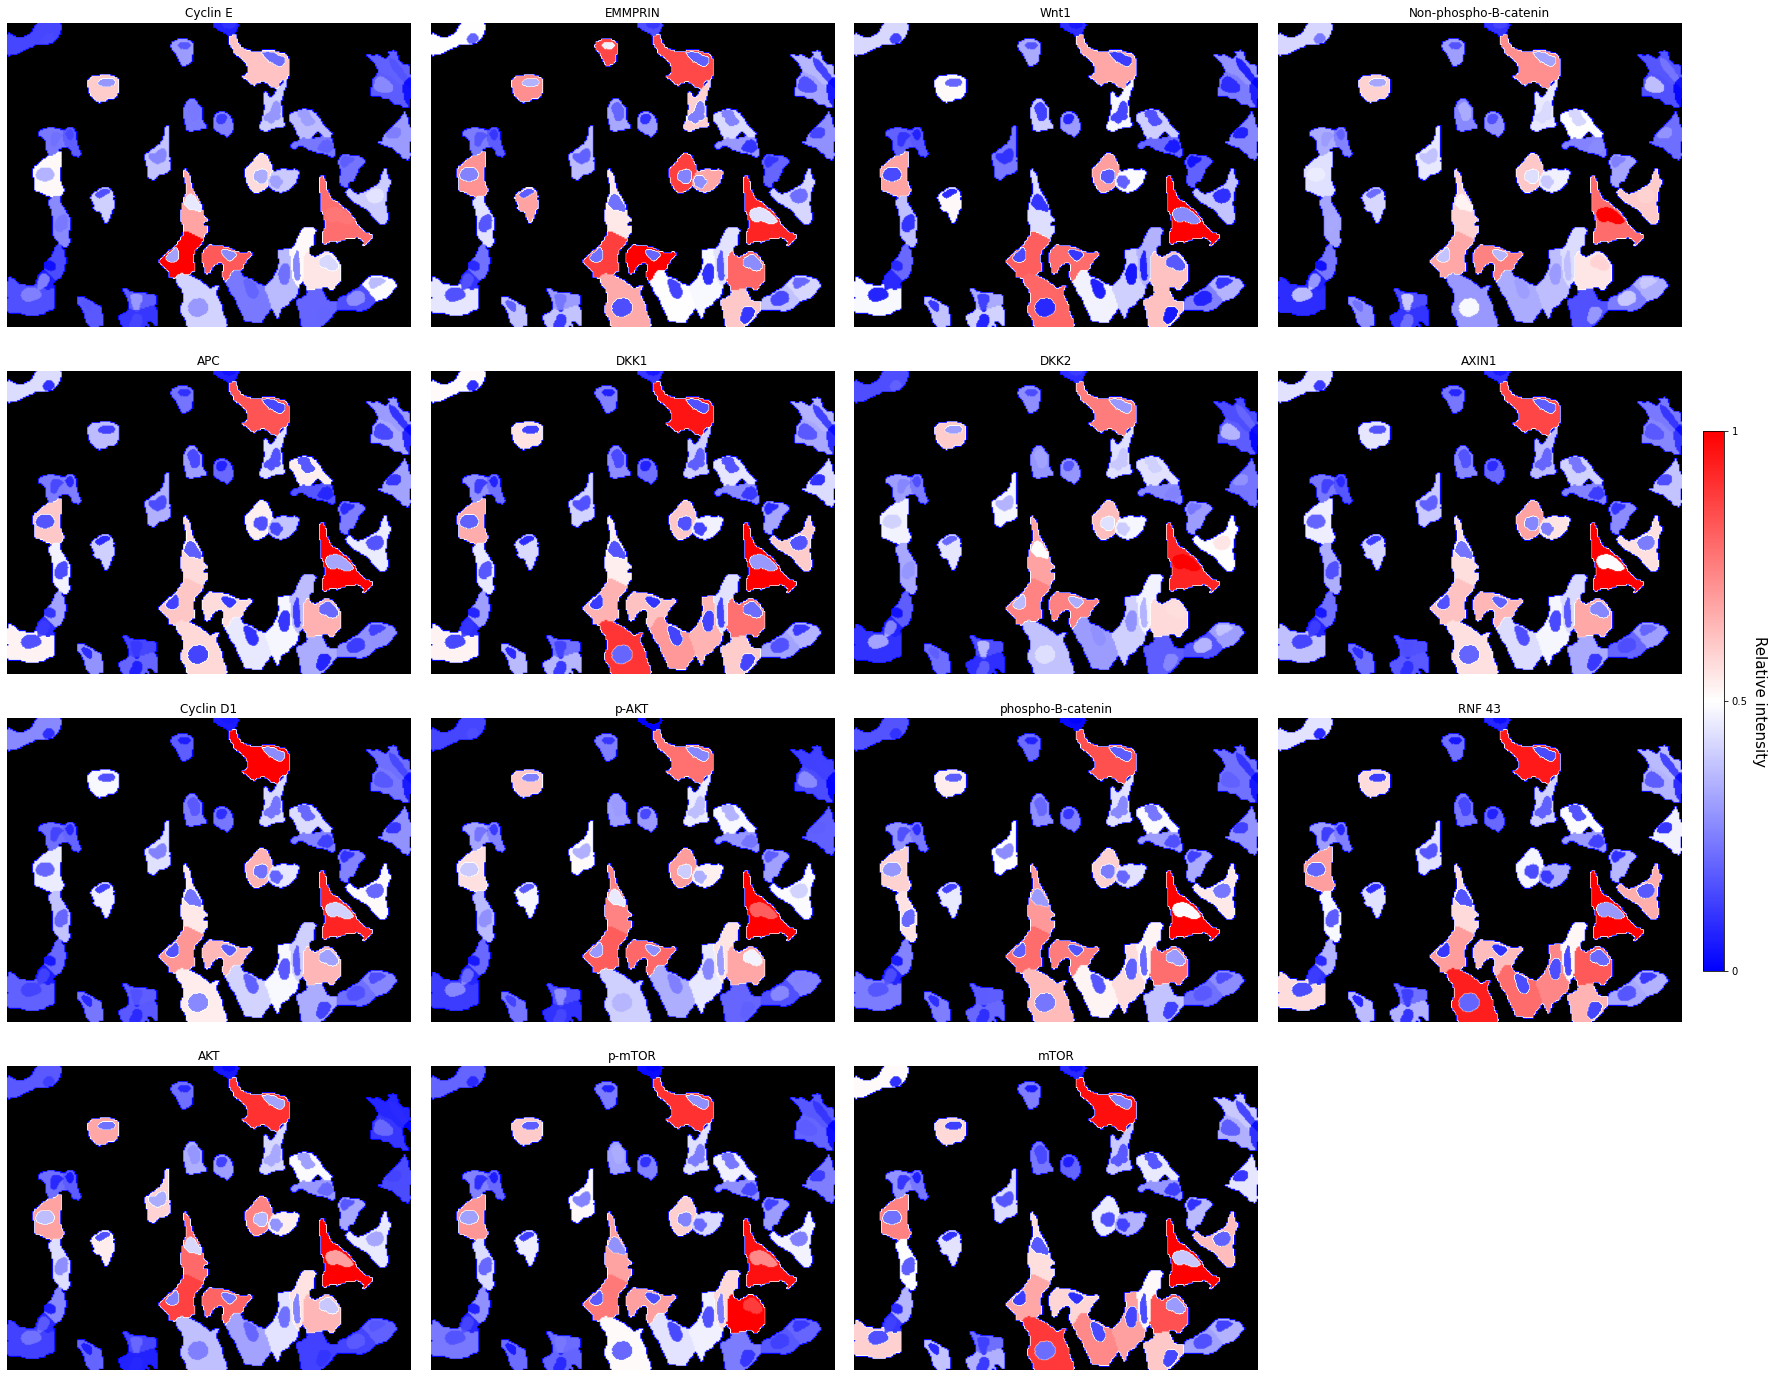

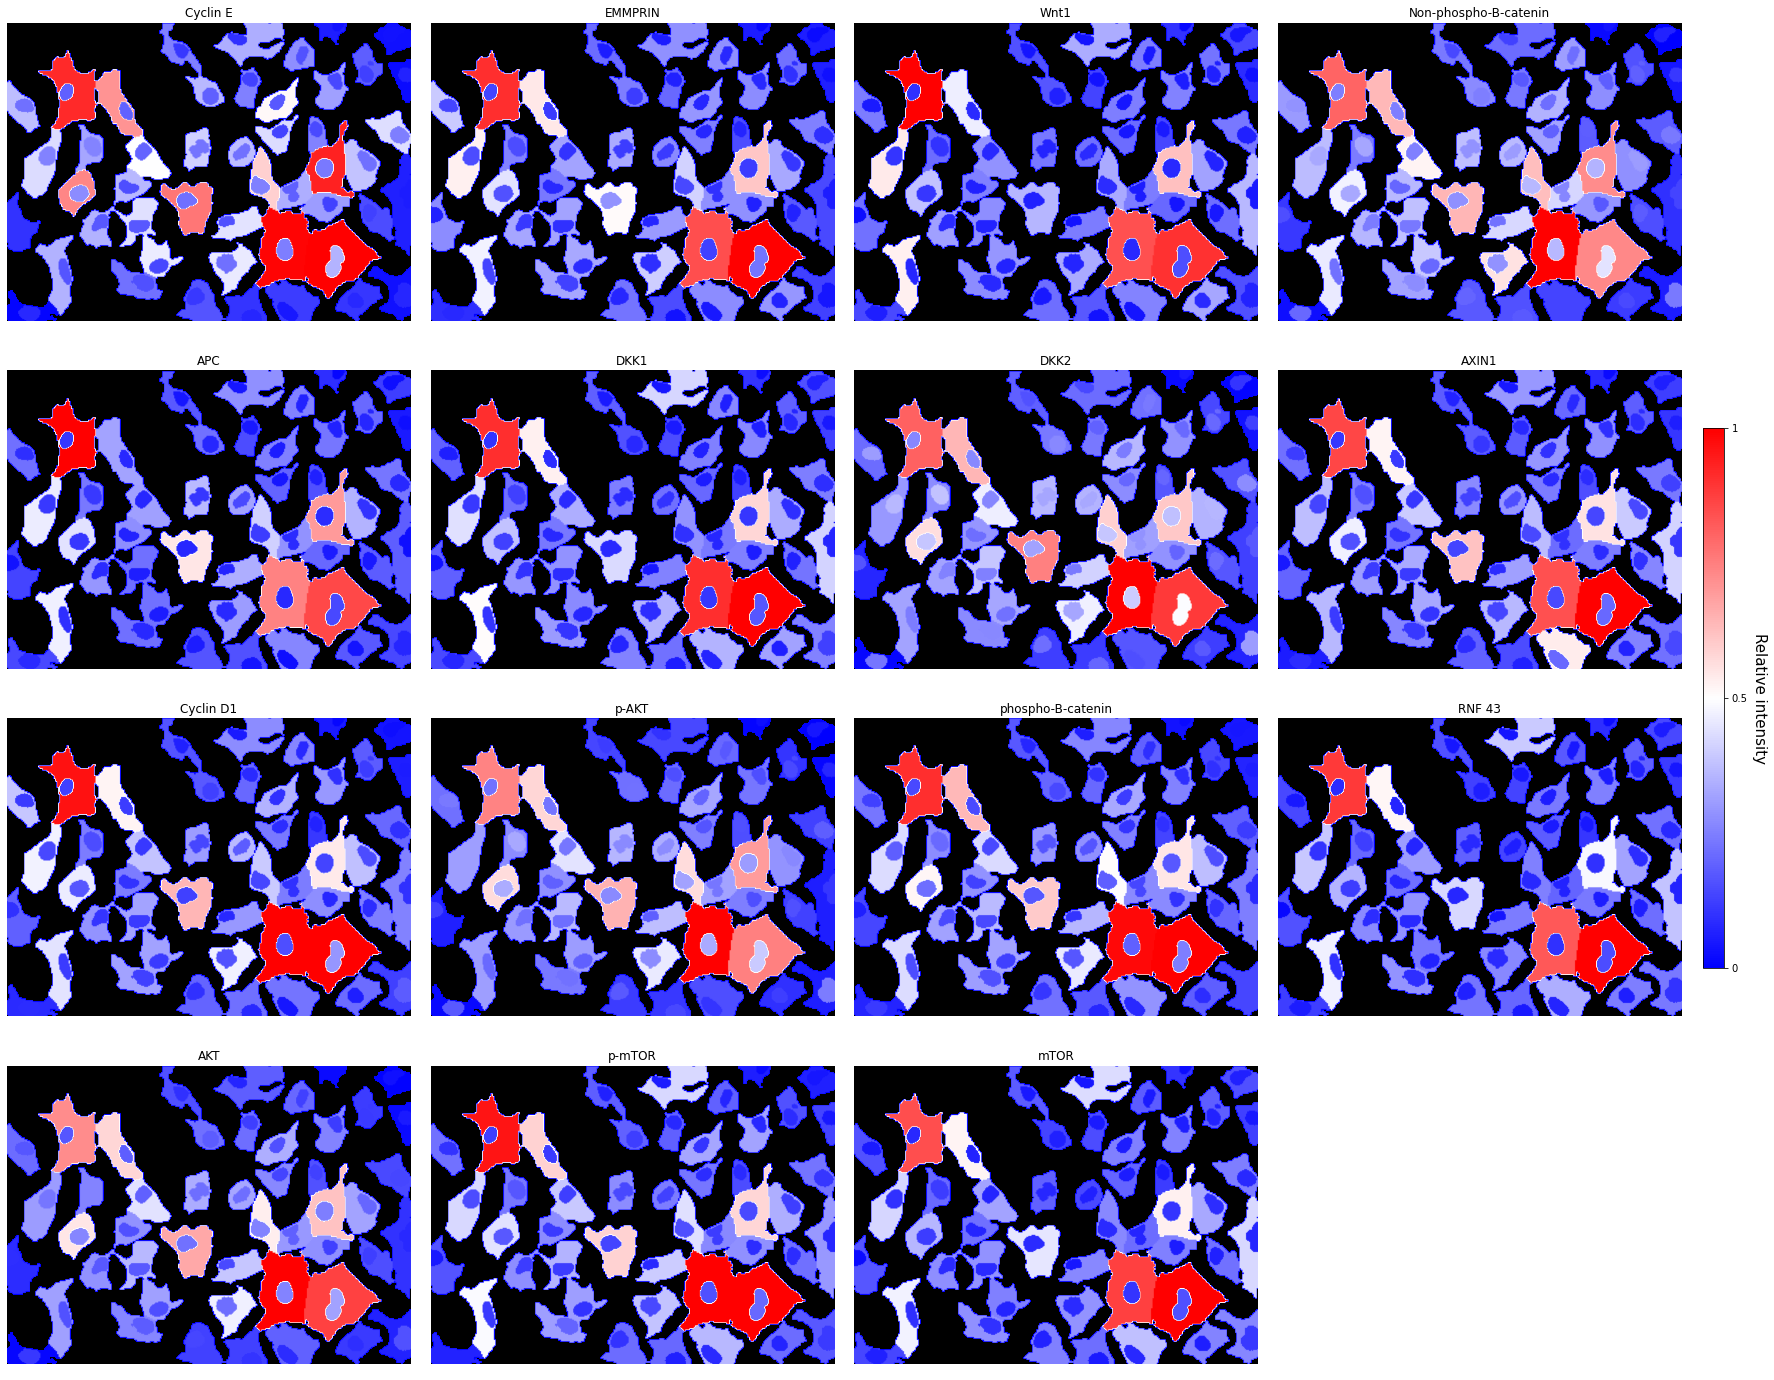

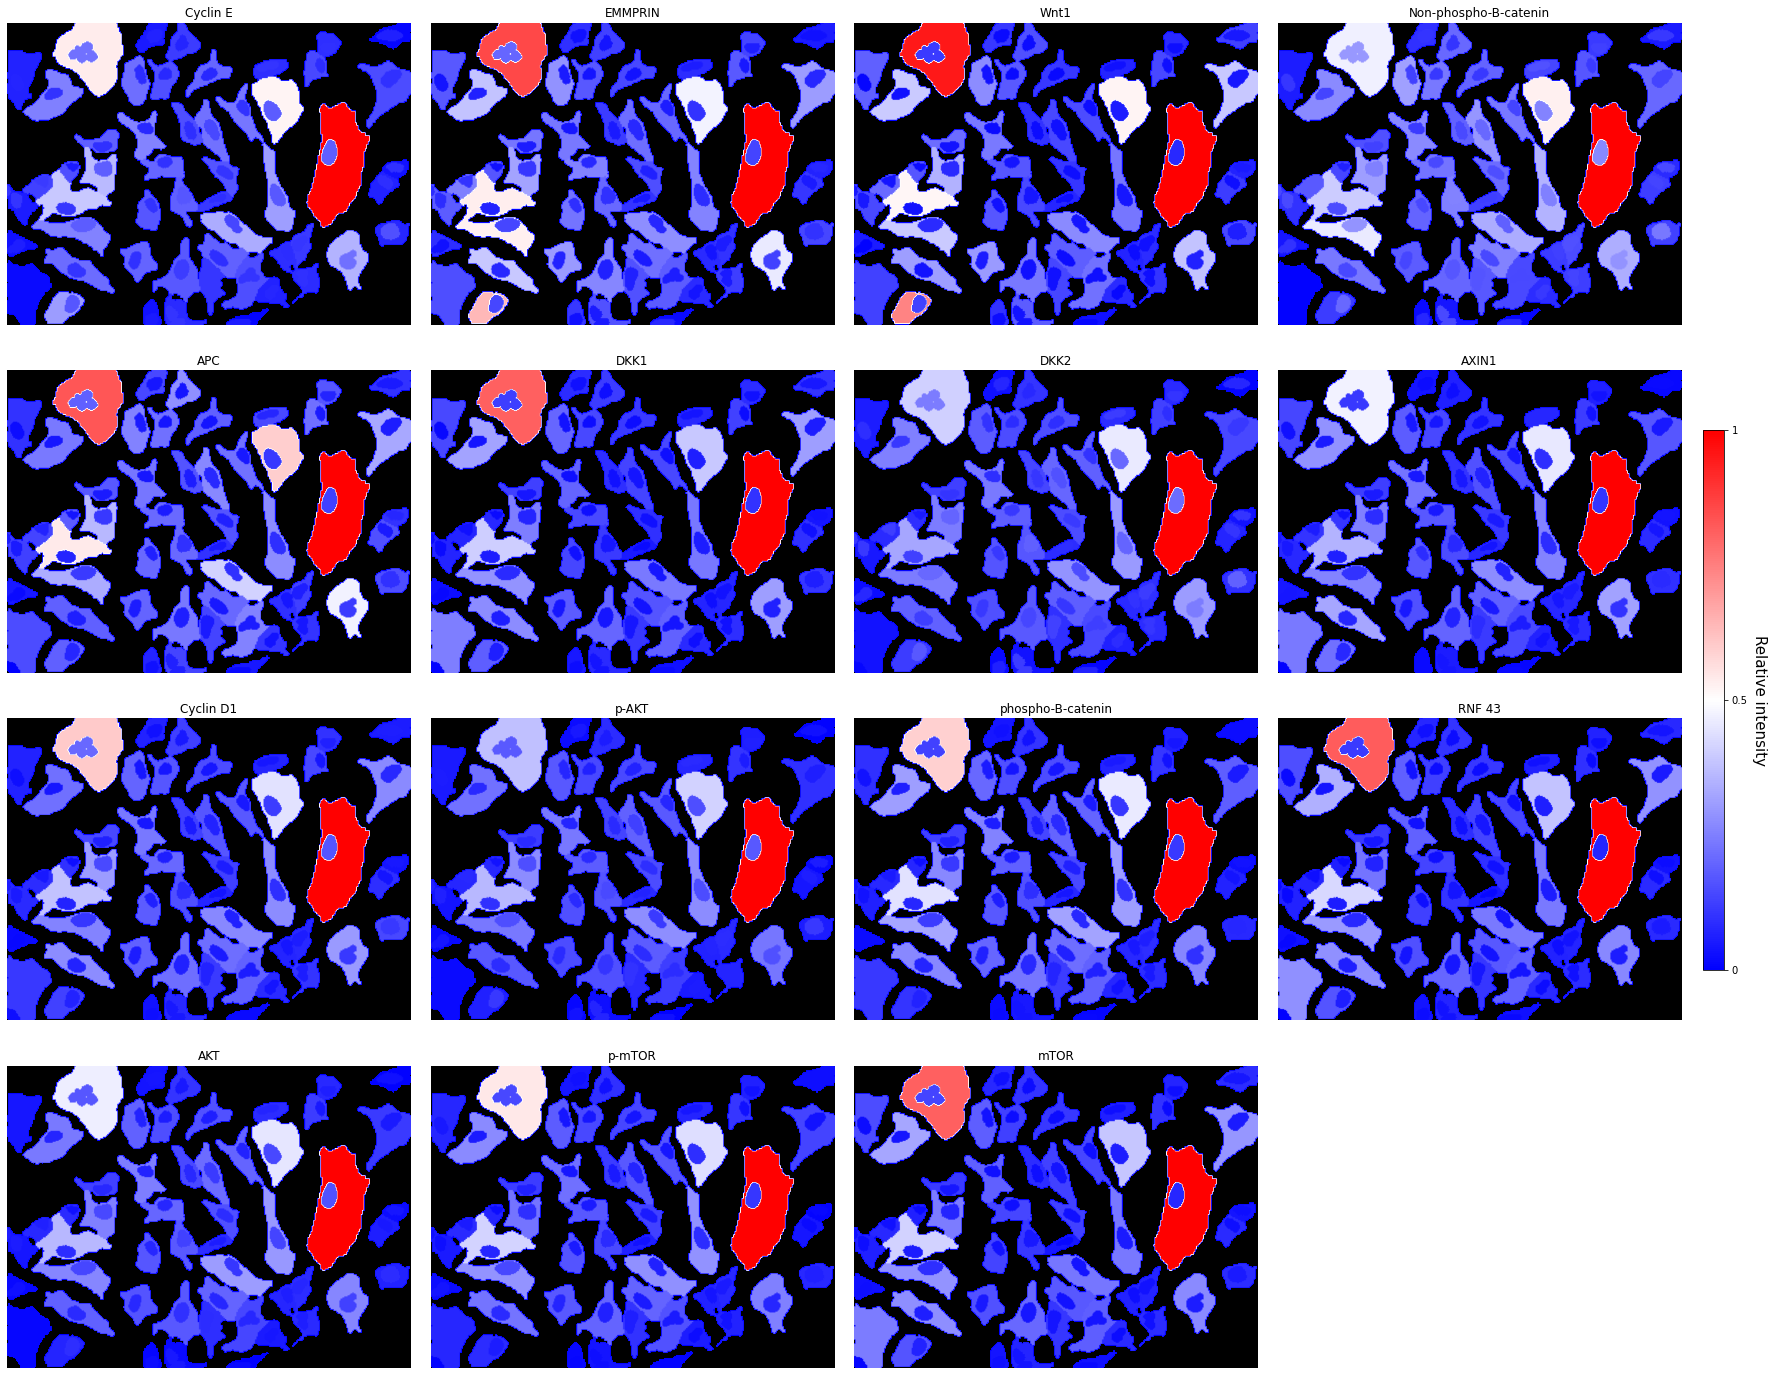

In [70]:
# Show total intensity

for idx, condition in enumerate(masks.keys()):
    mask_cyto = masks[condition]['cyto']
    mask_nuclei = masks[condition]['nuclei']
    df_intensity_subset = df_intensity[df_intensity.Location == int(condition)]
    imgs, markers = create_expression_img(
        mask_cyto, mask_nuclei, df_intensity_subset, mean=False)

    plot_expression_img(imgs, markers, condition, mean=False)